In [5]:
import numpy as np
import pandas as pd
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt

In [7]:
file_path = 'Audio_Song_Actors_01-24/Actor_01/03-02-01-01-01-01-01.wav'

audio_data, sample_rate = librosa.load(file_path)
print(audio_data)
print(sample_rate)

[-8.0983085e-14 -9.1273180e-14  8.6197298e-14 ... -7.2330103e-08
  6.9512943e-08 -6.5543659e-08]
22050


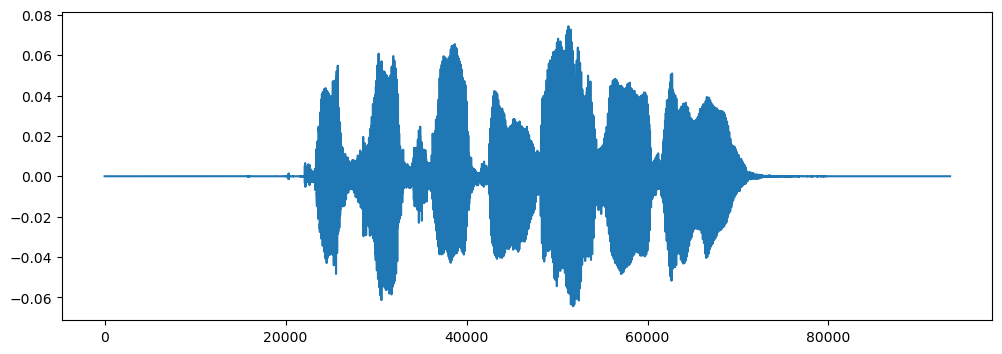

In [6]:
plt.figure(figsize=(12,4))
plt.plot(audio_data)

In [8]:
#extract features
mfccs = librosa.feature.mfcc(y = audio_data,sr = sample_rate, n_mfcc = 40)
mfccs.shape

(40, 183)

In [9]:
mfccs

array([[-787.9381, -787.9381, -787.9381, ..., -787.9381, -787.9381,
        -787.9381],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)

In [12]:
def preprocess_audio(file_path, target_sr=22050):
    y, sr = librosa.load(file_path, sr=None)
    y, _ = librosa.effects.trim(y)

    y = librosa.util.normalize(y)
    if y.ndim > 1:
        y = librosa.to_mono(y)
    
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    return y, sr

In [18]:
def add_noise(y, noise_level=0.005):
    noise = np.random.randn(len(y))  # Create random noise
    y_noisy = y + noise_level * noise
    return y_noisy
def augment_audio(y, sr):
    augmented = []
    augmented.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=2))

    augmented.append(librosa.effects.time_stretch(y, rate=0.9))
    augmented.append(add_noise(y))
    augmented.append(np.roll(y, 2000))

    return augmented


In [40]:
import os

# All parent folders
base_folders = ["Audio_Song_Actors_01-24", "Audio_Speech_Actors_01-24"]

# Emotion class mapping
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

original_data = []

for base_folder in base_folders:
    for actor_folder in os.listdir(base_folder):
        actor_path = os.path.join(base_folder, actor_folder)

        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(actor_path, file)
                    
                    # Extract emotion code from file name
                    emotion_code = file.split("-")[2]
                    emotion_label = emotion_map.get(emotion_code, "unknown")
                    
                    # Preprocess audio
                    y, sr = preprocess_audio(file_path)

                    # Original audio
                    original_data.append((file_path, y, sr, emotion_label))


In [41]:
for path, audio, sr,emotion_label in audio_data[:3]:
    print(f"File: {path}, Duration: {len(audio)/sr:.2f} seconds, Sample Rate: {sr},Emotional_label: {emotion_label}")


File: Audio_Song_Actors_01-24/Actor_16/03-02-03-02-02-02-16.wav, Duration: 3.41 seconds, Sample Rate: 22050,Emotional_label: happy
File: Audio_Song_Actors_01-24/Actor_16/03-02-03-01-01-02-16.wav, Duration: 4.07 seconds, Sample Rate: 22050,Emotional_label: happy
File: Audio_Song_Actors_01-24/Actor_16/03-02-02-02-01-01-16.wav, Duration: 4.17 seconds, Sample Rate: 22050,Emotional_label: calm


In [42]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(original_data, test_size=0.2, stratify=[e[3] for e in original_data], random_state=42)


In [43]:
train_data_augmented = []

for file_path, y, sr, emotion in train_data:
    train_data_augmented.append((file_path, y, sr, emotion))  # original

    for i, y_aug in enumerate(augment_audio(y, sr)):
        train_data_augmented.append((file_path + f"_aug{i}", y_aug, sr, emotion))  # augmented


In [44]:
def extract_features(y, sr):
    features = {}

    # 1. MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features['mfcc'] = np.mean(mfcc.T, axis=0)

    # 2. Chroma
    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    features['chroma'] = np.mean(chroma.T, axis=0)

    # 3. Spectral Contrast
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
    features['contrast'] = np.mean(contrast.T, axis=0)

    # 4. Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features['zcr'] = np.mean(zcr.T, axis=0)

    # 5. Root Mean Square Energy
    rmse = librosa.feature.rms(y=y)
    features['rmse'] = np.mean(rmse.T, axis=0)

    return features


In [46]:
def extract_features_from_data(data_list):
    processed = []
    for file_path, y, sr, emotion in data_list:
            feats = extract_features(y, sr)
            all_features = np.concatenate([
                feats['mfcc'],
                feats['chroma'],
                feats['contrast'],
                feats['zcr'],
                feats['rmse']
            ])
    return processed

train_processed = extract_features_from_data(train_data_augmented)
test_processed = extract_features_from_data(test_data)


In [47]:
from sklearn.preprocessing import StandardScaler
# Training set
X_train = np.array([row[1] for row in train_processed])
y_train = np.array([row[2] for row in train_processed])
# Testing set
X_test = np.array([row[1] for row in test_processed])
y_test = np.array([row[2] for row in test_processed])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)       


In [49]:
df_train = pd.DataFrame(X_train_scaled)
df_train['emotion'] = y_train

df_test = pd.DataFrame(X_test_scaled)
df_test['emotion'] = y_test
df_train

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,emotion
0,-1.504092,-0.797707,0.403086,0.179520,0.570780,1.397587,1.365087,1.212378,0.516443,1.312687,...,1.521326,-0.868810,-0.978935,-0.918765,-1.061384,-0.846915,0.281675,-1.574906,-1.031520,fearful
1,-1.504092,-0.797707,0.403086,0.179520,0.570780,1.397587,1.365087,1.212378,0.516443,1.312687,...,1.521326,-0.868810,-0.978935,-0.918765,-1.061384,-0.846915,0.281675,-1.574906,-1.031520,fearful
2,-1.903186,-0.924998,0.264899,-0.009717,0.326352,1.262188,0.871203,0.806679,0.855322,1.663181,...,1.369811,-0.796477,-0.827920,-0.557929,-0.223362,-0.474206,0.506123,-1.360638,-1.499137,fearful
3,-2.041012,-0.746408,0.368181,0.060220,0.488345,1.432338,1.320776,1.174685,0.417605,1.294588,...,1.519903,-0.793597,-0.856299,-0.467714,-0.628551,-0.478765,0.315795,-1.364519,-1.543471,fearful
4,0.821157,-1.662389,0.689804,-0.246374,0.456790,1.044001,1.258397,1.426342,0.816839,0.682934,...,0.022960,-1.170935,-1.545120,-1.597336,-1.768955,-1.784194,-2.269328,1.114817,-0.981776,fearful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11761,0.525229,0.805457,0.479238,0.962730,0.754320,-0.014411,-0.049691,0.064125,-1.618412,0.685398,...,1.108806,-1.119934,-0.553186,-0.663645,-0.440955,0.536754,0.485077,-0.413041,0.182054,surprised
11762,0.224513,0.784236,0.206855,0.862340,-0.069606,-0.557187,-0.774362,-0.883935,-0.907581,1.351295,...,1.262742,-1.160883,-0.692321,-0.423086,0.275041,1.164228,0.548413,-0.520524,-0.672510,surprised
11763,0.156509,0.900786,0.334040,0.788024,0.639098,-0.135134,-0.325279,-0.166886,-1.995674,0.503888,...,1.230924,-1.194085,-0.495278,-0.432055,0.166765,1.072061,0.515128,-0.637341,-0.659840,surprised
11764,1.866276,-0.496973,0.772997,0.563674,0.516980,0.102655,0.243541,0.397823,-0.991938,-0.131941,...,-0.489840,-1.184878,-1.036055,-1.269782,-1.193297,-0.845434,-2.133040,1.063812,0.221284,surprised


In [50]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(df_train['emotion'])
y_test_enc = label_encoder.transform(df_test['emotion'])

num_classes = len(label_encoder.classes_)


In [51]:
# For CNN & RNN: add time-step dimension
X_train_seq = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_seq = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


In [83]:
 def train_models(X_train, y_train, X_train_seq, y_train_seq, num_classes):
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import (
        Dense, Dropout, Flatten, Conv1D, MaxPooling1D,
        BatchNormalization, LSTM, Bidirectional
    )
    import xgboost as xgb

    models = {}

    # 1. CNN - Deep and regularized
    model_cnn = Sequential([
        Conv1D(128, 5, activation='relu', input_shape=(X_train_seq.shape[1], 1)),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        Conv1D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_cnn.fit(X_train_seq, y_train_seq, epochs=30, batch_size=32, verbose=0)
    models['CNN'] = model_cnn

    # 2. RNN - Bidirectional LSTM
    model_rnn = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_seq.shape[1], 1)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_rnn.fit(X_train_seq, y_train_seq, epochs=30, batch_size=32, verbose=0)
    models['RNN'] = model_rnn

    # 3. XGBoost - tuned parameters
    model_xgb = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=num_classes,
        n_estimators=300,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        verbosity=0
    )
    model_xgb.fit(X_train, y_train)
    models['XGBoost'] = model_xgb

    # 4. Dense Neural Network (MLP)
    model_nn = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_nn.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)
    models['NeuralNetwork'] = model_nn

    return models


In [84]:
def evaluate_models(models, X_test, y_test, X_test_seq):
    for name, model in models.items():
        print(f"\n🔍 Evaluating {name} model:")
        
        if name in ['CNN', 'RNN']:
            y_pred = model.predict(X_test_seq)
            y_pred = y_pred.argmax(axis=1)
        elif name == 'NeuralNetwork':
            y_pred = model.predict(X_test)
            y_pred = y_pred.argmax(axis=1)
        else:
            y_pred = model.predict(X_test)
        
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


In [85]:
# Train
models = train_models(X_train_scaled, y_train_enc, X_train_seq, y_train_enc, num_classes)

# Evaluate
evaluate_models(models, X_test_scaled, y_test_enc, X_test_seq)


/Users/indr/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔍 Evaluating CNN model:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.6965
F1 Score: 0.6926
Classification Report:
              precision    recall  f1-score   support

       angry       0.84      0.84      0.84        75
        calm       0.70      0.93      0.80        75
     disgust       0.54      0.51      0.53        39
     fearful       0.62      0.53      0.58        75
       happy       0.74      0.64      0.69        75
     neutral       0.86      0.63      0.73        38
         sad       0.59      0.63      0.61        75
   surprised       0.70      0.77      0.73        39

    accuracy                           0.70       491
   macro avg       0.70      0.69      0.69       491
weighted avg       0.70      0.70      0.69       491


🔍 Evaluating RNN model:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.5866
F1 Score: 0.5854
Classification Report:
              precision    recall  f1-score   support

       angry       0.69      0.61      0.65       

In [77]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam

# def build_strong_nn(input_dim, num_classes):
#     model = Sequential([
#         Dense(512, activation='relu', input_shape=(input_dim,)),
#         BatchNormalization(),
#         Dropout(0.4),

    #     Dense(256, activation='relu'),
    #     BatchNormalization(),
    #     Dropout(0.4),

    #     Dense(128, activation='relu'),
    #     BatchNormalization(),
    #     Dropout(0.3),

    #     Dense(64, activation='relu'),
    #     Dropout(0.3),

    #     Dense(num_classes, activation='softmax')
    # ])

    # optimizer = Adam(learning_rate=0.0005)  # lower LR for better convergence

    # model.compile(
    #     optimizer=optimizer,
    #     loss='sparse_categorical_crossentropy',
    #     metrics=['accuracy']
    # )

    # return model
